In [200]:
# Reviews dataset
import pandas as pd
from food_extractor.food_model import FoodModel
model = FoodModel("chambliss/distilbert-for-food-extraction")
reviews = pd.read_csv('assessment_dataset.csv',encoding='utf-8')
#reviews['reviewText'].str.encode('ascii', 'ignore').str.decode('ascii')


In [201]:

#extract food ptypes from external knowledge dictionary
from nltk.stem import WordNetLemmatizer
import re
lemmatizer = WordNetLemmatizer()
ptypes = set()
def extract_ptype_from_node(node_text):
    return re.split(r' & |, ', node_text)

for line in open("google_taxonomy.txt"):
    toks = line.lower().strip().split(" > ")
    if "food, beverages & tobacco" not in toks[0]:
        continue
    last = toks[len(toks)-1]
    second_last = toks[len(toks)-2]
    tax_ptypes = set()
    for tok in extract_ptype_from_node(last):
        tax_ptypes.add(lemmatizer.lemmatize(tok))
    for tok in extract_ptype_from_node(second_last):
        tax_ptypes.add(lemmatizer.lemmatize(tok)) 
    ptypes = ptypes.union(tax_ptypes)

for line in open("food_ptypes.txt"):
    line = line.strip().lower()
    if ";" in line:
        toks = line.strip(";").split(",")
        for tok in toks:
            ptypes.add(lemmatizer.lemmatize(tok.strip()))
        



In [202]:
#extract food entites from nltk
from nltk.corpus import wordnet as wn
food = wn.synset('food.n.02')
ptypes_nltk = list(set([w.lower() for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))

ptypes_nltk = set([ptype.replace("_"," ") for ptype in ptypes_nltk])
print(len(ptypes))
ptypes = ptypes.union(ptypes_nltk)
print(len(ptypes))

525
1967


c:\Users\btr\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('lunch_meat.n.01') at depth 3
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\btr\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('headcheese.n.01') at depth 3
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\btr\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('haslet.n.01') at depth 3
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\btr\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('leg_of_lamb.n.01') at depth 5
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\btr\AppData\Local\

In [204]:
#clean food entity dictionary
#ptypes.remove("bilion")
ptypes.remove("delicious")

In [205]:
# functions to tag food product type from reviews and also get sentiment
import spacy
nlp = spacy.load("en_core_web_sm")
from string import punctuation
from textblob import TextBlob, Word

def get_ptypes_from_bert(toks):
    text = " ".join([lemmatizer.lemmatize(tok) for tok in toks])
    ptypes = set()
    try:
        bert_output = model.extract_foods(text)
    except:
        return ptypes

    
    for doc in bert_output:
        ingreds = doc["Ingredient"]
        for ing in ingreds:
            ptypes.add(ing["text"])
    return ptypes

def get_ptypes_from_sentence(toks):
    review_ptypes = set()
    for i in range(1,len(toks)):
        unigram = toks[i-1]
        bigram = toks[i-1]+ " "+ toks[i]
        bigram_proc = lemmatizer.lemmatize(bigram)
        unigram_proc = lemmatizer.lemmatize(unigram)
        #print(bigram_proc)
        if bigram_proc in ptypes:
            review_ptypes.add(bigram_proc)
        elif unigram_proc in ptypes:
            review_ptypes.add(unigram_proc)
        elif i ==len(toks)-1:
                unigram = toks[i]
                unigram_proc = lemmatizer.lemmatize(unigram)
                if unigram_proc in ptypes:
                    review_ptypes.add(unigram_proc)
    return review_ptypes


def get_ptypes(text):
    sent = TextBlob(text)
    ptypes = set()
    for sentence in sent.sentences:
        words = sentence.words
        words = [''.join(c for c in s if c not in punctuation) for s in words]
        words = [s for s in words if s] 
        ptypes_sent = get_ptypes_from_sentence(words)
        ptypes_bert = get_ptypes_from_bert(words)
        ptypes = ptypes.union(ptypes_sent)
        ptypes = ptypes.union(ptypes_bert)
    
    return list(ptypes)

def get_sentiment_score(text):
    sent = TextBlob(text)
    ptypes = set()
    ind = 0
    sentiment_scores = 0.0
    for sentence in sent.sentences:
        sentiment_scores += sentence.sentiment.polarity
        ind+=1
    return sentiment_scores/ind

    
def extract_hashtags(text):
    sent = TextBlob(text)
    hashtags = set()
    for sentence in sent.sentences:
        for word in sentence.split(" "):
            if len(word)<1:
                continue
            if word[0] == '#':
                hashtags.add(word)
    return list(hashtags)     





In [206]:
#extract features from the reviews and add new columns
reviews["foodEntities"] = reviews["reviewText"].apply(get_ptypes)
reviews["sentiment_score"] = reviews["reviewText"].apply(get_sentiment_score)
reviews["hashtags"] = reviews["reviewText"].apply(extract_hashtags)

In [207]:
reviews.head(10)

,reviewText,reviewBrand,brandCategory,country,reviewDate,likesCount,commentsCount,foodEntities,sentiment_score,hashtags
0,Margarina vegetal para preparar todo tipo de c...,4018,food,Argentina,2021-01-20 06:12:16.975,2.0,0,[garina],0.000000,"[#veganuary, #elparaisodelosanimales]"
1,No sé si es la más cremosa pero está rica. Tir...,4568,food,Argentina,2021-02-25 16:12:00.830,15.0,0,[],0.166667,[]
2,Really tasty crackers! Oven baked but with onl...,3485,food,South Africa,2021-03-03 10:56:34.895,2.0,0,[cracker],0.316667,[]
3,"Es una salsa más salada que picante, pero el p...",2290,food,Mexico,2021-03-04 22:19:59.747,0.0,0,"[sals, riosalvaje, elparaisodelosanimal, anima...",0.025000,"[#animallibre, #elparaisodelosanimales, #santu..."
4,a couple of these biscuits proves 3 gram prote...,234,food,NaN,2021-01-11 17:47:20.337,1.0,0,[biscuit],0.150000,[#cinnaMonday]
5,This was tasty. It has rich creamy flavour and...,5132,food,Singapore,2021-02-12 00:30:24.653,10.0,0,"[soy, soy milk, water, ie smoothie abillionlove]",0.139583,"[#vegansmoothie, #abillionlove, #smoothie]"
6,The flavor isn’t my favorite but considering i...,1039,food,Slovenia,2021-02-26 10:01:49.506,11.0,0,"[shed potato, potato, sugar]",0.282500,[#abillionlove]
7,Leaves my dry from smooth and soft and it's sc...,15349,health and beauty,Sweden,2021-03-16 17:57:47.925,2.0,0,[],0.233333,[]
8,Almond milk made in Spain. The taste is really...,368,food,NaN,2021-02-12 12:32:34.790,4.0,0,"[Almond milk, billinlove, milk]",0.200000,[#ditchdairy]
9,"Baileys pero con almendra en lugar de leche, e...",62,food,Spain,2021-01-01 18:33:49.526,0.0,0,[],0.000000,[]


# Insight 1: Distribution of food entities for popular brands

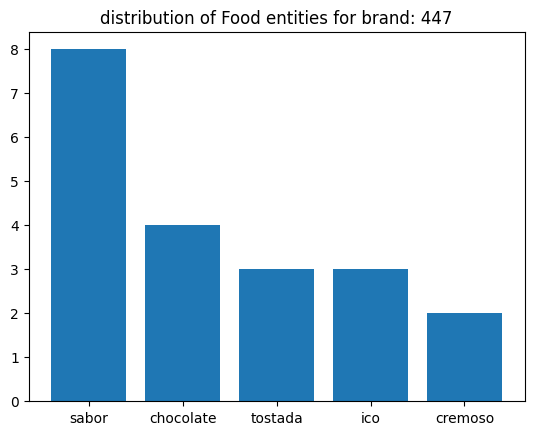

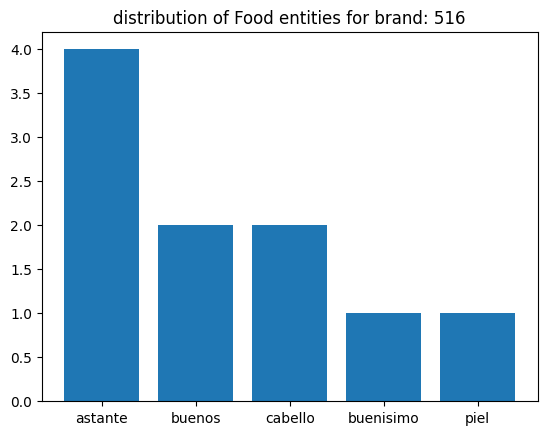

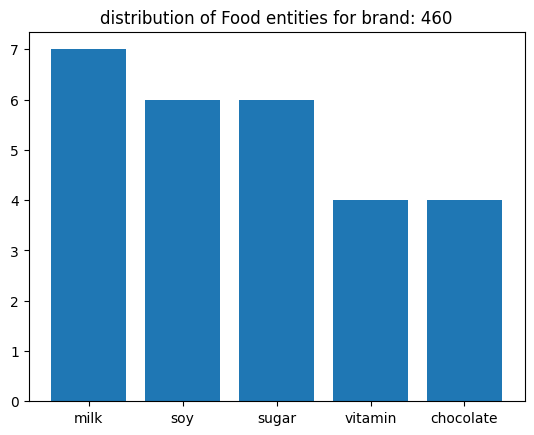

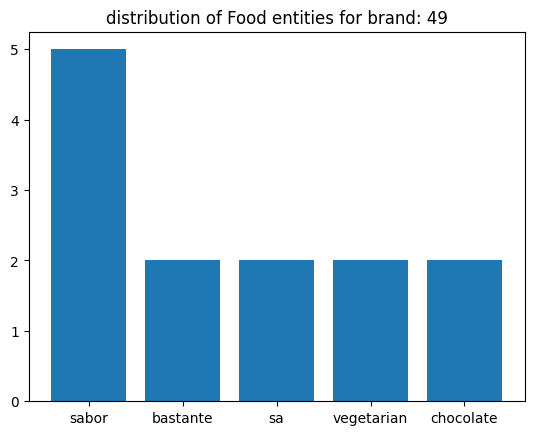

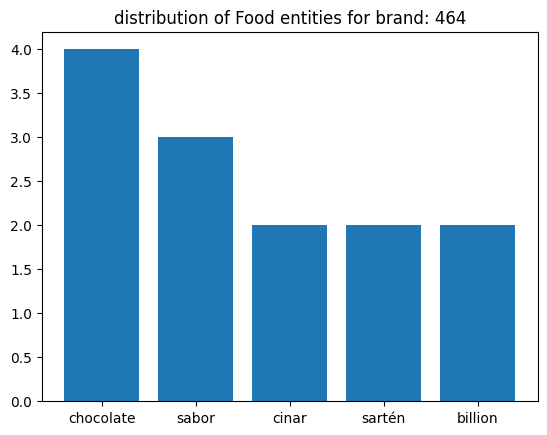

In [208]:
#plot food entity distribution per brand
#sentiment_score
import matplotlib.pyplot as plt
top_5_brands = list(reviews['reviewBrand'].value_counts().nlargest(5).keys())
brand_ptype_sentiments = {}
brand_ptype_likes = {}
def search(x,y):
    if y in x:
        return True
    else:
        return False

for brand in top_5_brands:
    brand_ptypes = reviews[reviews["reviewBrand"]==brand]["foodEntities"]
    ptype_dist = {}
    for ptype_li in list(brand_ptypes):
        for ptype in ptype_li:
            if ptype in ptype_dist:
                ptype_dist[ptype]+=1
            else:
                ptype_dist[ptype]=1
    ptype_dist_sorted = {}
    ptype_sentiment = {}
    ptype_likes = {}
    for ptype  in sorted(ptype_dist, key=ptype_dist.get, reverse=True)[:5]:
        ptype_dist_sorted[ptype] = ptype_dist[ptype]
        ptype_sentiment[ptype] = reviews[reviews["foodEntities"].apply(lambda x: ptype in x)]["sentiment_score"].mean()
        ptype_likes[ptype] = reviews[reviews["foodEntities"].apply(lambda x: ptype in x)]["likesCount"].mean()
    brand_ptype_sentiments[brand] = ptype_sentiment
    brand_ptype_likes[brand] = ptype_likes
    plt.bar(range(5), list(ptype_dist_sorted.values()), tick_label=list(ptype_dist_sorted.keys()))
    plt.title('distribution of Food entities for brand: '+str(brand))
    plt.show()

# Insight 2: Average sentiment score for food entities brand wise

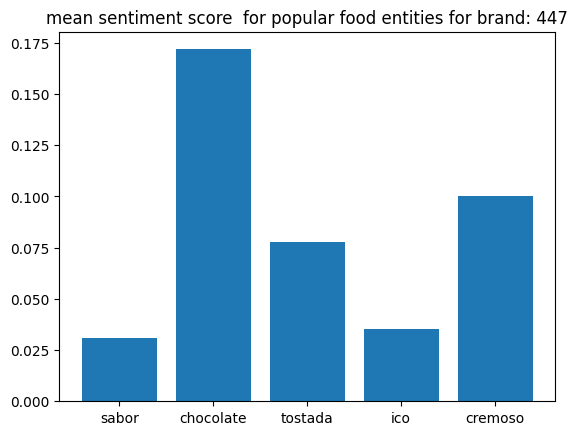

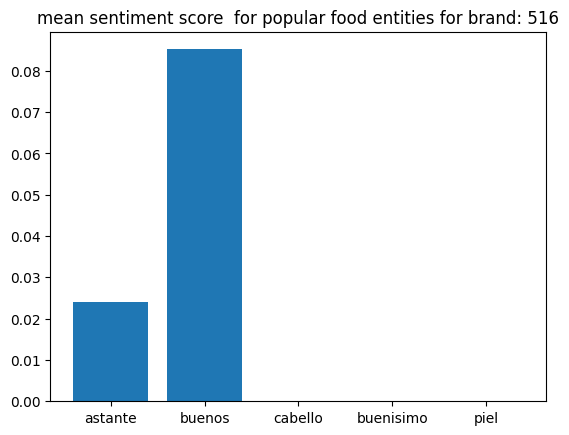

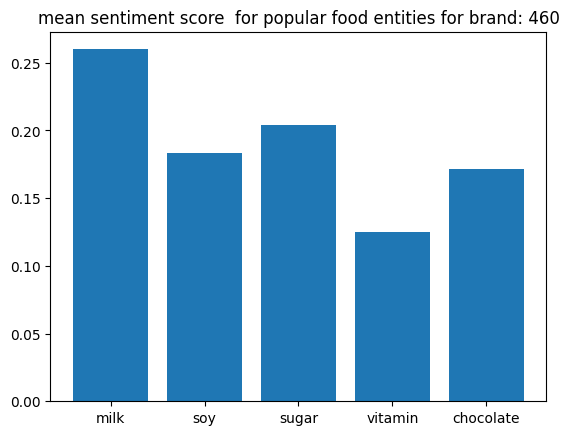

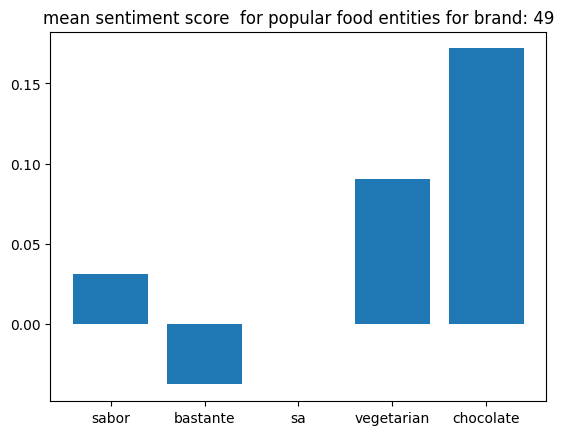

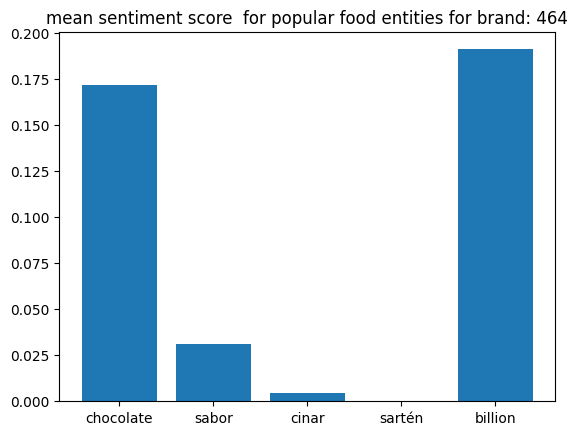

In [209]:
for brand,ptype_sentiments in brand_ptype_sentiments.items():
    plt.bar(range(5), list(ptype_sentiments.values()), tick_label=list(ptype_sentiments.keys()))
    plt.title('mean sentiment score  for popular food entities for brand: '+str(brand))
    plt.show()

# Insight 3: Average no of likes for popular food entites brand wise

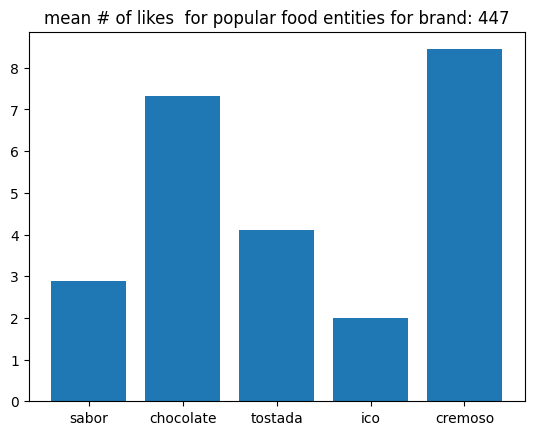

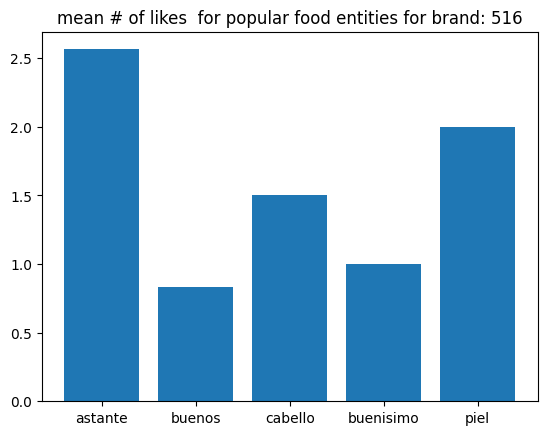

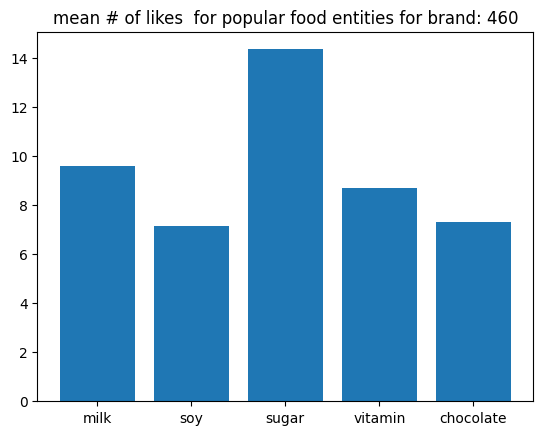

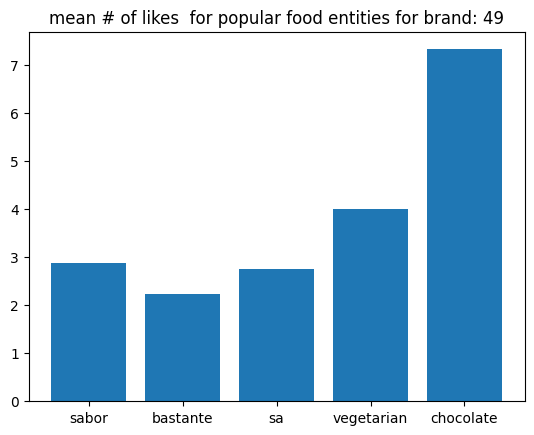

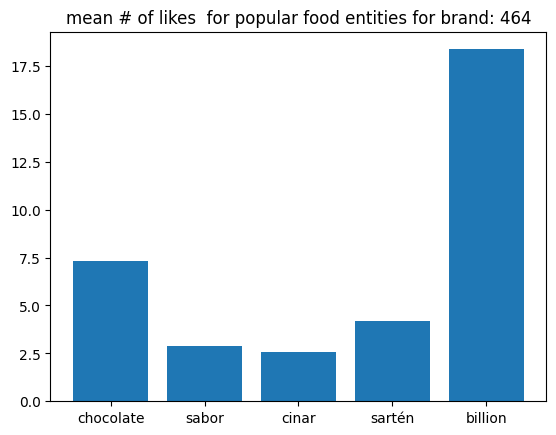

In [210]:
for brand,ptype_likes in brand_ptype_likes.items():
    plt.bar(range(5), list(ptype_likes.values()), tick_label=list(ptype_likes.keys()))
    plt.title('mean # of likes  for popular food entities for brand: '+str(brand))
    plt.show()




# Insight 4: Top brands for popular countries

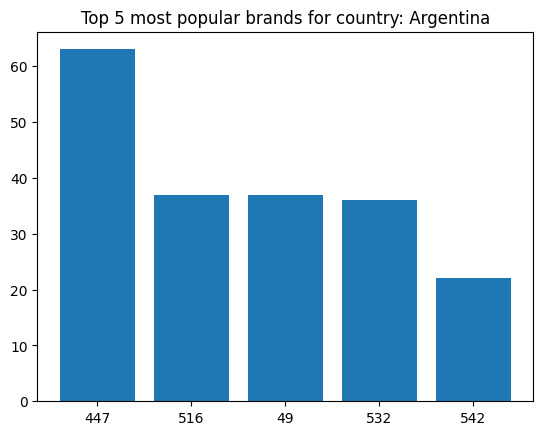

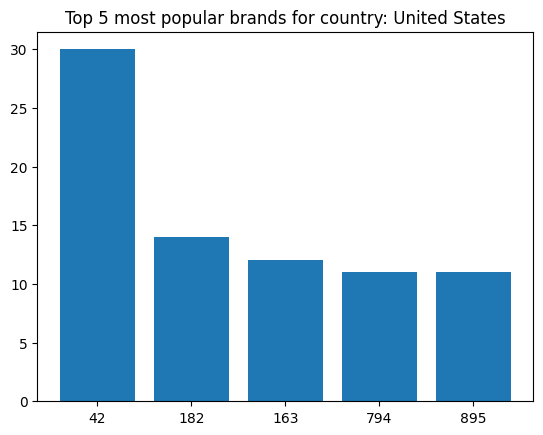

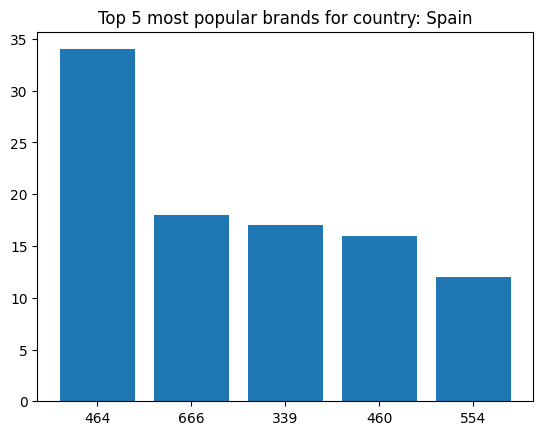

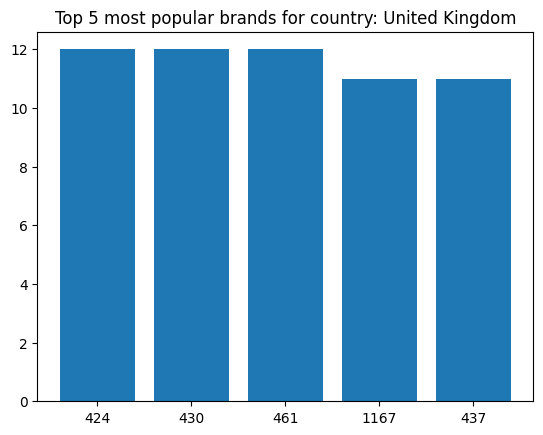

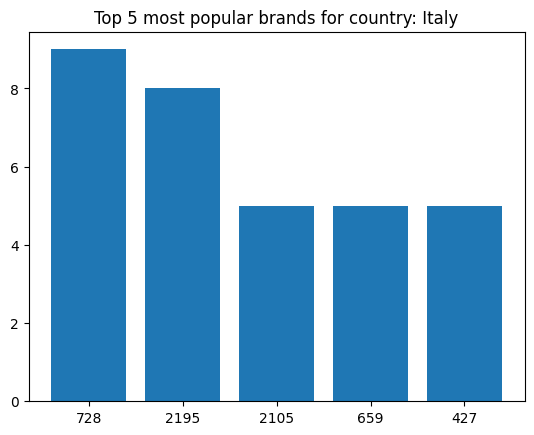

['Argentina', 'United States', 'Spain', 'United Kingdom', 'Italy']


In [211]:
#top 5 popular brands for top 5 popular countries
#reviewBrand
top_5_countries = list(reviews['country'].value_counts().nlargest(5).keys())
for country in top_5_countries:
    pop_brands = dict(reviews[reviews["country"]==country]["reviewBrand"].value_counts().nlargest(5))
    plt.bar(range(5), list(pop_brands.values()), tick_label=list(pop_brands.keys()))
    plt.title('Top 5 most popular brands for country: '+str(country))
    plt.show()

print(top_5_countries)

# Insight 5: Popular hashtags globally

{'#abillionlove': 455, '#veganuary': 435, '#ditchdairy': 74, '#uplandspeak': 58, '#veganin2021': 49}


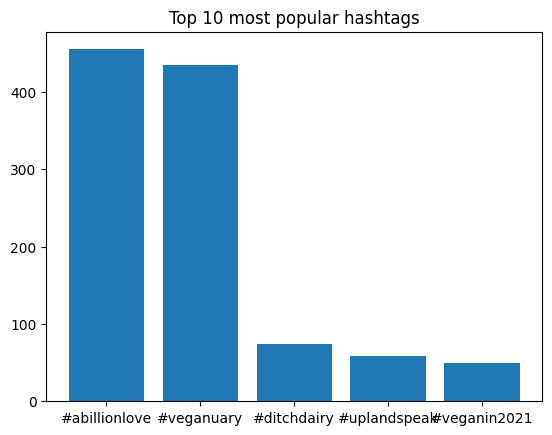

In [212]:
 
#df.colors.explode().dropna().value_counts() 

pop_hashtags = dict(reviews.hashtags.explode().dropna().value_counts().nlargest(5))
print(pop_hashtags)
plt.bar(range(5), list(pop_hashtags.values()), tick_label=list(pop_hashtags.keys()))
plt.title("Top 10 most popular hashtags")
plt.show()

# Insight 6: Average no of User activities for popular countries

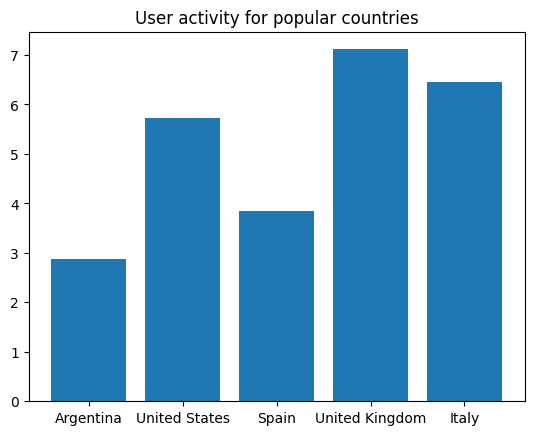

In [213]:
#User activity = commentsCount + likesCount
reviews["userActivity"] = reviews["likesCount"] + reviews["commentsCount"]
pop_country_ub = {}
for country in top_5_countries:
    pop_country_ub[country] = reviews[reviews["country"]==country]["userActivity"].mean()
plt.bar(range(5), list(pop_country_ub.values()), tick_label=list(pop_country_ub.keys()))
plt.title('User activity for popular countries')
plt.show()


# Insight 7: Popular food entities country wise

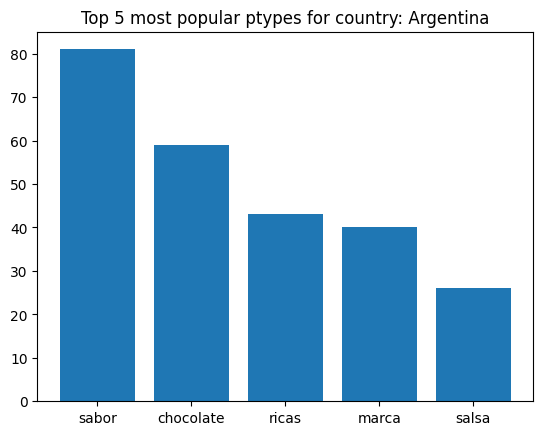

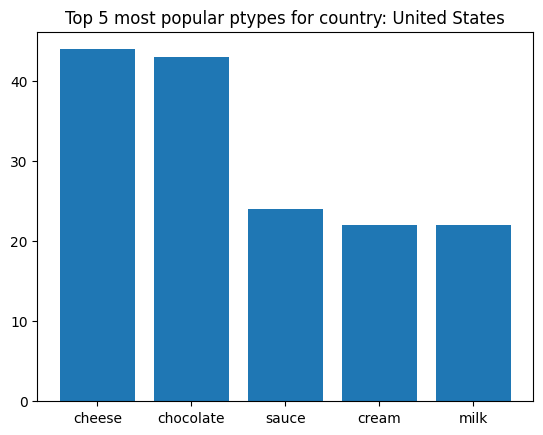

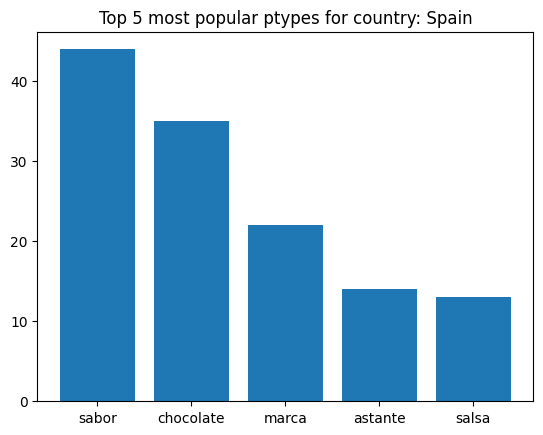

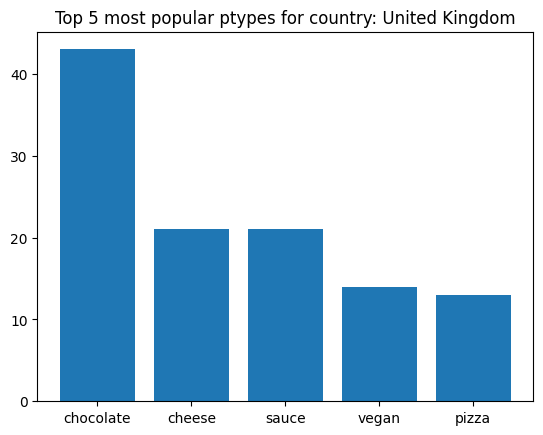

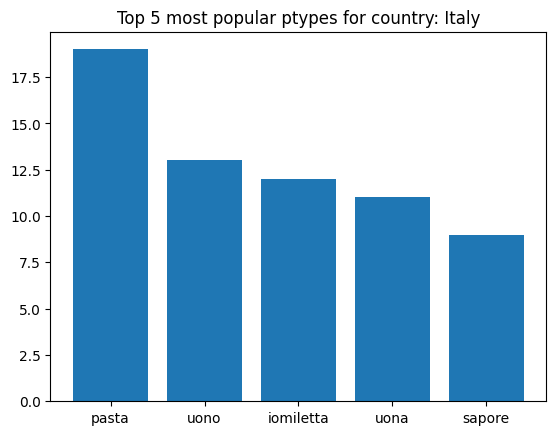

In [214]:
for country in top_5_countries:
    pop_ptypes = dict(reviews[reviews["country"]==country].foodEntities.explode().dropna().value_counts().nlargest(5))
    plt.bar(range(5), list(pop_ptypes.values()), tick_label=list(pop_ptypes.keys()))
    plt.title('Top 5 most popular ptypes for country: '+str(country))
    plt.show()


# Section B

Given your experience on the app, what are some new features or feature enhancements (that involve data) you can think of? How might you go about implementing this feature?

**Answer**  
An interesting feature would be...